<a href="https://colab.research.google.com/github/aboagyeso/Kinase_activity/blob/master/Copy_of_Deep_Learning_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

###### Define the functions

In [0]:
#@title Default title text
test_form = 89
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [0]:

def add_gausian(y,mu,sigma):
    noise = np.random.normal(mu,sigma,[4175, 117])
    df_aug = df_train_set +noise 
    #df_new = pd.concat([df_train_set,df_aug])
    return(df_aug)

def drop_corr(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column]>0.95)]
    df_new = df.drop(df[to_drop],axis = 1)
    return(df_new)

def model_eval(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    #model_score = model.score(X_test,y_test)
    model_mse =  mse(y_test,pred)
    model_r2 =r2(y_test,pred)
    return(-model_mse, model_r2)

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['KinaseP00533.csv']))
df.head()

,Unnamed: 0,target_id,pAc,smiles,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,2609,P00533,1.60,C1=CC(=CC=C1CCC(=O)C2=C(C=C(C=C2O)O)O)O,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5,4,4,4,5,0,5,20,34,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,10.575418,6.031726,4.448645,2.937401,1.928546,6.031726,4.448645,2.937401,...,0,0,0,0,0,0,0,0,5,0,20,8,1,0,6,6,4,10,5,4,4,0,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0,0
1,2610,P00533,1.72,C1=CC(=C(C=C1/C=C/C(=O)C2=C(C(=C(C=C2)O[C@H]3[...,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11,8,6,8,11,0,11,32,54,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,16.437764,9.401589,7.069336,4.897849,3.050766,9.401589,7.069336,4.897849,...,0,0,0,0,0,0,0,0,10,1,32,14,2,0,12,6,6,22,11,8,8,0,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0,0
2,2611,P00533,1.96,C[C@@H](C(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)...,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12,3,8,3,10,2,13,41,70,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,23.298170,13.260590,9.762369,6.999277,4.859648,12.882625,9.355169,6.722681,...,0,1,0,0,0,0,2,6,4,0,41,14,3,0,17,11,8,16,12,3,3,0,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1
3,2612,P00533,1.99,COC1=C(C=C(C(=C1)N2CCN(CC2)C(=O)N3CCNCC3)NC(=O...,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13,3,7,3,10,3,14,44,77,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,25.049247,14.699534,10.767781,7.988250,5.622447,14.321570,10.360580,7.711653,...,0,1,0,0,0,0,2,8,3,0,44,12,3,0,23,11,7,16,13,3,3,0,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2,1
4,2613,P00533,2.00,CN(C)CC(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)NC...,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12,2,9,2,10,2,13,42,74,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,24.427927,13.700574,10.379680,7.134408,4.994960,13.322609,9.972480,6.857811,...,0,1,0,0,0,0,3,6,3,0,42,15,3,0,17,11,9,15,12,2,2,0,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1


# New Section

In [0]:
#Check the shape of the dataframe
df.shape

(4639, 120)

In [0]:
#Drop the highly correlated features
drop_corr(df).head()

,Unnamed: 0,target_id,smiles,SlogP,SMR,TPSA,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,HallKierAlpha,slogp_VSA1,slogp_VSA2,slogp_VSA3,slogp_VSA4,slogp_VSA5,slogp_VSA6,slogp_VSA7,slogp_VSA8,slogp_VSA10,slogp_VSA11,slogp_VSA12,smr_VSA1,smr_VSA2,...,peoe_VSA7,peoe_VSA8,peoe_VSA9,peoe_VSA10,peoe_VSA11,peoe_VSA12,peoe_VSA13,peoe_VSA14,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN13,MQN14,MQN15,MQN16,MQN20,MQN24,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41
0,2609,P00533,C1=CC(=CC=C1CCC(=O)C2=C(C=C(C=C2O)O)O)O,2.3245,72.1947,97.99,5,4,4,4,5,0,5,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,-2.69,0.000000,26.209355,6.420822,0.0,22.342262,36.398202,0.000000,0.00000,0.000000,22.998047,0.00000,25.220647,0.0,...,24.117007,18.553556,0.000000,28.561499,5.783245,0.000000,0.00000,0.000000,0,0,0,0,0,0,0,0,5,0,8,1,0,6,10,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0
1,2610,P00533,C1=CC(=C(C=C1/C=C/C(=O)C2=C(C(=C(C=C2)O[C@H]3[...,-0.4162,107.3029,197.37,11,8,6,8,11,0,11,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,-3.35,4.736863,83.948238,4.736863,0.0,15.921440,36.407855,0.000000,6.07602,0.000000,28.747559,0.00000,55.120482,0.0,...,35.904940,0.000000,12.170333,24.415866,28.781292,12.039539,0.00000,0.000000,0,0,0,0,0,0,0,0,10,1,14,2,0,12,22,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0
2,2611,P00533,C[C@@H](C(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)...,3.3508,156.8052,137.22,12,3,8,3,10,2,13,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,-4.68,20.270350,80.795623,9.589074,0.0,6.923737,61.577322,5.022633,16.77408,23.010498,5.749512,11.60094,19.432465,0.0,...,31.198859,44.005688,52.798906,11.853478,0.000000,11.855519,5.90718,0.000000,0,1,0,0,0,0,2,6,4,0,14,3,0,17,16,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2
3,2612,P00533,COC1=C(C=C(C(=C1)N2CCN(CC2)C(=O)N3CCNCC3)NC(=O...,3.4686,169.9561,132.26,13,3,7,3,10,3,14,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,-4.88,25.587138,100.787999,4.794537,0.0,0.000000,61.577322,5.022633,16.77408,27.805035,5.749512,11.60094,14.325937,0.0,...,24.275121,70.184713,52.798906,5.749512,0.000000,11.855519,0.00000,6.031115,0,1,0,0,0,0,2,8,3,0,12,3,0,23,16,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2
4,2613,P00533,CN(C)CC(=O)N1CCN(CC1)C2=CC(=C(C=C2NC(=O)C=C)NC...,3.5316,163.6784,120.23,12,2,9,2,10,2,13,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,-4.68,20.270350,95.125139,9.589074,0.0,0.000000,61.577322,5.022633,16.77408,23.010498,5.749512,11.60094,14.325937,0.0,...,38.370465,44.005688,59.343662,5.749512,0.000000,17.762699,0.00000,0.000000,0,1,0,0,0,0,3,6,3,0,15,3,0,17,15,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2


In [0]:
drop_corr(df).shape

(4639, 93)

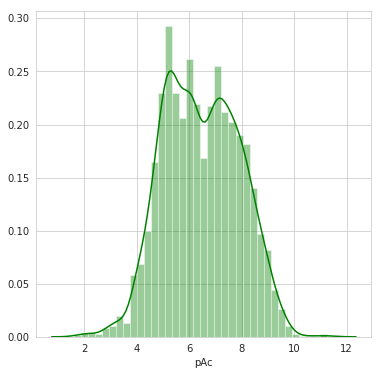

In [0]:
#Plot distribution of the pAc with the density estimation function
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df.pAc,color = 'green');
sns.set_style("whitegrid")

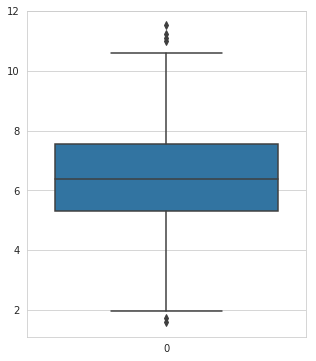

In [0]:
#Boxplot of pAc,It has a few outliers but the distribution in fairly normal
f, ax = plt.subplots(figsize=(5, 6))
sns.set_style("whitegrid")
data = df.pAc
sns.boxplot(data=data);

In [0]:
#Drop unwanted colum(unnamed)
df = df.drop(['Unnamed: 0','smiles','target_id'], axis=1)
df.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,1.60,2.3245,72.1947,114.921781,97.99,274.272,274.084124,5,4,4,4,5,0,5,20,34,0,0,2,2,0,0,0,0,0,2,0,0,0.133333,10.575418,6.031726,4.448645,2.937401,1.928546,6.031726,4.448645,2.937401,1.928546,-2.69,13.734989,...,0,0,0,0,0,0,0,0,5,0,20,8,1,0,6,6,4,10,5,4,4,0,0,5,2,1,0,6,6,0,0,0,0,2,0,0,0,0,0,0
1,1.72,-0.4162,107.3029,180.820025,197.37,450.396,450.116212,11,8,6,8,11,0,11,32,54,5,0,3,2,1,1,0,1,1,2,0,0,0.285714,16.437764,9.401589,7.069336,4.897849,3.050766,9.401589,7.069336,4.897849,3.050766,-3.35,23.315994,...,0,0,0,0,0,0,0,0,10,1,32,14,2,0,12,6,6,22,11,8,8,0,0,9,4,1,0,6,12,0,0,0,0,3,0,0,0,0,0,0
2,1.96,3.3508,156.8052,240.763560,137.22,577.045,576.200029,12,3,8,3,10,2,13,41,70,1,0,5,4,1,1,3,1,1,1,0,0,0.250000,23.298170,13.260590,9.762369,6.999277,4.859648,12.882625,9.355169,6.722681,4.666795,-4.68,27.870591,...,0,1,0,0,0,0,2,6,4,0,41,14,3,0,17,11,8,16,12,3,3,0,0,7,4,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1
3,1.99,3.4686,169.9561,259.003075,132.26,617.114,616.242563,13,3,7,3,10,3,14,44,77,0,0,6,4,2,2,3,2,2,1,0,0,0.300000,25.049247,14.699534,10.767781,7.988250,5.622447,14.321570,10.360580,7.711653,5.429594,-4.88,29.203414,...,0,1,0,0,0,0,2,8,3,0,44,12,3,0,23,11,7,16,13,3,3,0,0,5,4,2,0,20,13,0,0,0,1,5,0,0,0,0,2,1
4,2.00,3.5316,163.6784,248.094102,120.23,590.088,589.231664,12,2,9,2,10,2,13,42,74,0,0,5,4,1,1,3,1,1,1,0,0,0.275862,24.427927,13.700574,10.379680,7.134408,4.994960,13.322609,9.972480,6.857811,4.802107,-4.68,28.834518,...,0,1,0,0,0,0,3,6,3,0,42,15,3,0,17,11,9,15,12,2,2,0,0,7,5,3,0,15,12,0,0,0,1,4,0,0,0,0,2,1


###### Standardize the dataframe

In [0]:
# Get column names first
names = df.columns
# Create the Scaler object
scaler = StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=names)
scaled_df.head()

,pAc,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,...,MQN2,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
0,-3.395662,-1.375843,-1.536783,-1.407165,0.376955,-1.434036,-1.431595,-0.769461,1.452924,-0.668270,1.792964,-0.553589,-0.753247,-1.193402,-1.290045,-1.153872,-0.362549,-0.280565,-1.541329,-1.372628,-0.573187,-0.706852,-1.645034,-0.543950,-0.661276,0.082580,-0.18303,-0.236131,-0.508119,-1.508341,-1.431825,-1.382218,-1.360787,-1.294443,-1.296276,-1.202602,-1.213923,-1.184701,0.637144,-1.139101,...,-0.557024,-0.712351,-0.473281,-0.054547,-0.520657,-0.025438,-1.733948,-1.739424,1.751370,-0.404729,-1.290045,-0.450576,-0.225524,-0.403211,-1.413178,-1.260041,-0.668270,0.229675,-0.769187,1.452924,1.792316,-0.223016,-0.224498,0.427001,-0.812916,-0.019599,-0.346342,-1.493197,-0.950378,-0.132247,-0.108594,-0.101279,-0.831579,-1.218004,-0.185317,-0.025438,-0.025438,-0.040873,-1.106345,-0.809684
1,-3.311830,-3.261856,-0.334842,0.063333,3.600130,0.159783,0.163996,1.810921,4.592241,-0.023154,5.303594,2.396554,-0.753247,1.076770,0.267815,0.225132,6.645225,-0.280565,-0.707678,-1.372628,1.284964,0.738316,-1.645034,1.466713,0.881036,0.082580,-0.18303,-0.236131,0.778174,-0.199654,-0.240280,-0.234481,-0.220323,-0.456645,-0.015651,0.085697,0.102354,-0.169252,-0.110036,0.524732,...,-0.557024,-0.712351,-0.473281,-0.054547,-0.520657,-0.025438,-1.733948,-1.739424,4.787698,1.773388,0.267815,0.971183,0.570675,-0.403211,-0.030161,-1.260041,-0.023154,3.430868,1.811209,4.592241,5.302047,-0.223016,-0.224498,2.383405,-0.102122,-0.019599,-0.346342,-1.493197,1.348668,-0.132247,-0.108594,-0.101279,-0.831579,-0.142162,-0.185317,-0.025438,-0.025438,-0.040873,-1.106345,-0.809684
2,-3.144165,-0.669594,1.359887,1.400955,1.649295,1.305883,1.306846,2.240985,0.668095,0.621962,0.915307,1.904864,1.739130,1.833494,1.436210,1.328336,1.039006,-0.280565,0.959624,0.646275,1.284964,0.738316,1.829535,1.466713,0.881036,-1.280721,-0.18303,-0.236131,0.476699,1.331835,1.124217,0.944939,1.002156,0.893783,1.307222,1.209383,1.327577,1.293024,-1.615717,1.315682,...,-0.557024,0.933364,-0.473281,-0.054547,-0.520657,-0.025438,0.184894,2.154659,1.144105,-0.404729,1.436210,0.971183,1.366874,-0.403211,1.122354,0.683091,0.621962,1.830272,2.241275,0.668095,0.914883,-0.223016,-0.224498,1.405203,-0.102122,1.874542,-0.346342,0.809557,1.348668,-0.132247,-0.108594,-0.101279,0.443692,0.933680,-0.185317,-0.025438,-0.025438,-0.040873,-0.047586,-0.058008
3,-3.123207,-0.588530,1.810113,1.807964,1.488428,1.668484,1.669800,2.671048,0.668095,0.299404,0.915307,1.904864,2.985319,2.211856,1.825675,1.810988,-0.362549,-0.280565,1.793275,0.646275,3.143114,2.183484,1.829535,3.477376,2.423348,-1.280721,-0.18303,-0.236131,0.898764,1.722739,1.633011,1.385261,1.577477,1.463253,1.854054,1.703631,1.991590,1.983247,-1.842135,1.547139,...,-0.557024,0.933364,-0.473281,-0.054547,-0.520657,-0.025438,0.184894,3.452687,0.536839,-0.404729,1.825675,0.497263,1.366874,-0.403211,2.505371,0.683091,0.299404,1.830272,2.671341,0.668095,0.914883,-0.223016,-0.224498,0.427001,-0.102122,0.927472,-0.346342,2.088865,1.731843,-0.132247,-0.108594,-0.101279,0.443692,2.009521,-0.185317,-0.025438,-0.025438,-0.040873,-0.047586,-0.058008
4,-3.116221,-0.545177,1.595193,1.564533,1.098261,1.423914,1.424967,2.240985,-0.116735,0.944519,0.037649,1.904864,1.739130,1.833494,1.566032,1.604137,-0.362549,-0.280565,0.959624,0.646275,1.284964

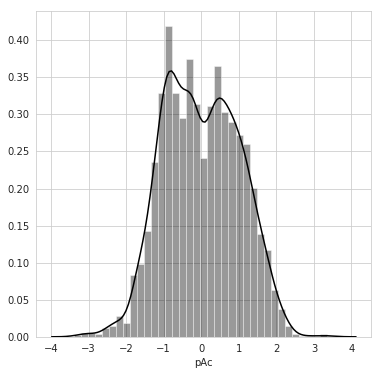

In [0]:
#Plot distribution of the pAc with the density estimation function after scaling
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(scaled_df.pAc,color = 'black');
sns.set_style("whitegrid")

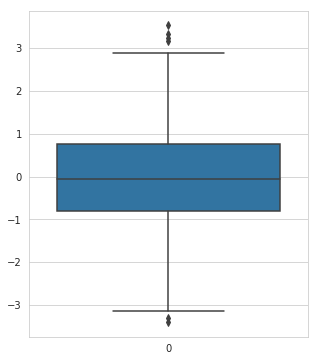

In [0]:
#Boxplot of pAc,It has a few outliers but the distribution in fairly normal
f, ax = plt.subplots(figsize=(5, 6))
sns.set_style("whitegrid")
data = scaled_df.pAc
sns.boxplot(data=data);

In [0]:
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

In [0]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [0]:
scaled_df.shape

(4639, 117)

In [0]:
# Get the feature vector
X = scaled_df.drop(columns=['pAc'],axis=1)
# Get the target vector
y = scaled_df["pAc"]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [0]:
#Check the shape of the training and testing data 
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((4175, 116), (464, 116), (4175,), (464,))

###### Add the X_train and y_train to form a a training set for augmentation

In [0]:
df_train_set = pd.concat([X_train, y_train], axis = 1)
df_train_set.head()

,SlogP,SMR,LabuteASA,TPSA,AMW,ExactMW,NumLipinskiHBA,NumLipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumAmideBonds,NumHeteroAtoms,NumHeavyAtoms,NumAtoms,NumStereocenters,NumUnspecifiedStereocenters,NumRings,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,NumAromaticHeterocycles,NumSaturatedHeterocycles,NumAliphaticHeterocycles,NumAromaticCarbocycles,NumSaturatedCarbocycles,NumAliphaticCarbocycles,FractionCSP3,Chi0v,Chi1v,Chi2v,Chi3v,Chi4v,Chi1n,Chi2n,Chi3n,Chi4n,HallKierAlpha,kappa1,kappa2,...,MQN3,MQN4,MQN5,MQN6,MQN7,MQN8,MQN9,MQN10,MQN11,MQN12,MQN13,MQN14,MQN15,MQN16,MQN17,MQN19,MQN20,MQN21,MQN22,MQN23,MQN24,MQN25,MQN26,MQN27,MQN28,MQN29,MQN30,MQN31,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42,pAc
1554,-0.793558,0.536678,0.853800,3.254072,1.569963,1.558462,1.380857,3.022582,0.621962,3.548279,0.921483,1.739130,1.455132,0.657280,0.156182,-0.362549,-0.280565,-1.541329,-1.372628,-0.573187,-0.706852,-1.645034,-0.543950,-0.661276,0.082580,-0.18303,-0.236131,-0.532586,0.821730,0.461051,0.459780,0.198057,-0.028225,0.135398,0.025021,-0.226496,-0.495942,-0.845895,1.207232,1.249341,...,-0.712351,3.904690,-0.054547,-0.520657,-0.025438,2.103736,-1.739424,2.358636,-0.404729,0.657280,1.919023,2.163073,3.852749,-1.413178,-1.260041,0.621962,1.830272,1.381143,3.022582,3.547182,-0.223016,-0.224498,2.872506,1.674863,2.821613,-0.346342,-2.004920,-0.184029,-0.132247,-0.108594,-0.101279,-0.831579,-1.218004,-0.185317,-0.025438,-0.025438,-0.040873,-1.106345,-0.809684,-0.550022
1736,-1.658122,-1.432417,-1.460322,1.043125,-1.421086,-1.422671,0.090667,3.022582,-1.313385,1.792964,-0.061899,-0.753247,-0.058316,-1.419867,-1.498624,-0.362549,-0.280565,-0.707678,-0.363176,-0.573187,-0.706852,0.671346,-0.543950,-0.661276,-1.280721,-0.18303,-0.236131,-1.633626,-1.538652,-1.511177,-1.431532,-1.447782,-1.270880,-1.525196,-1.472502,-1.472176,-1.328325,0.806958,-1.519453,-1.577601,...,0.933364,-0.473281,-0.054547,-0.520657,-0.025438,1.144315,0.856631,-1.284958,-0.404729,-1.419867,-1.161456,-1.021723,-0.403211,-0.952172,-0.482788,-1.313385,-0.570623,0.090945,3.022582,1.792316,-0.223016,-0.224498,-0.551201,-1.168313,-0.966669,-0.346342,-0.981474,-0.567204,-0.132247,-0.108594,-0.101279,0.443692,-1.218004,-0.185317,-0.025438,-0.025438,-0.040873,-0.047586,-0.058008,-0.423110
4285,0.756060,0.784706,0.916932,-0.226620,0.862081,0.862609,0.090667,-0.116735,1.267077,0.037649,-0.061899,0.492942,0.698408,0.916923,0.983585,-0.362549,-0.280565,0.125973,-0.363176,1.284964,0.738316,-0.486844,1.466713,0.881036,0.082580,-0.18303,-0.236131,0.867500,0.862078,0.819211,0.661107,0.570190,0.417626,0.979413,0.890791,0.816415,0.677675,-0.347775,1.077934,1.299283,...,0.933364,-0.473281,-0.054547,-0.520657,-0.025438,0.184894,0.207617,-0.070427,-0.404729,0.916923,1.208143,0.570675,-0.403211,0.430845,-0.094162,1.267077,-0.037091,0.090945,-0.116735,0.037450,-0.223016,-0.224498,0.427001,0.964069,0.927472,-0.346342,0.553696,0.199145,-0.132247,-0.108594,-0.101279,0.443692,-0.142162,-0.185317,-0.025438,-0.025438,-0.040873,-1.106345,-0.809684,1.438665
149,-0.557962,-0.735686,-0.871705,-0.125106,-1.034848,-1.032089,-0.339397,-0.116735,-1.313385,-0.840009,-0.061899,-0.753247,-0.815040,-0.770759,-0.602271,-0.362549,-0.280565,0.125973,0.646275,-0.573187,-0.706852,1.829535,-0.543950,-0.661276,-1.280721,-0.18303,-0.236131,0.242219,-0.776249,-0.768279,-0.613214,-0.679145,-0.545089,-0.583123,-0.339420,-0.427199,-0.276450,0.263554,-0.995034,-1.239872,...,-0.712351,-0.473281,-0.054547,-0.520657,-0.025438,-0.774527,1.505645,-1.284958,-0.404729,-0.770759,-0.924496,-1.021723,-0.403211,-0.260663,0.294465,-1.313385,-0.837389,-0.339121,-0.116735,-0.839983,-0.223016,-0.224498,-0.062100,-1.523710,-0.019599,-0.346342,-0.469751,0.199145,-0.132247,-0.108594,-0.101279,0.443692,-0.142162,-0.185317,-0.025438,-0.025438,-0.040873,1.011173,0.693668,-1.719017
4609,0.090124,0.004003,0.017532,-0.226620,-0.007604,-0.007895,0.090667,-0.116735,0.621962,0.037649,-0.061899,0.492942,0.320046,0.008172,0.156182

In [0]:
#Assign df0 to df_train_set
df0 = df_train_set

In [0]:
#The shape of the training set
df0.shape

(4175, 117)

In [0]:
# Get the feature vector
X0 = df0.drop(columns=['pAc'],axis=1).values
# Get the target vector
y0 = df0["pAc"].values

In [0]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.3,random_state=42)
X0_train.shape,y0_train.shape,X0_test.shape,y0_test.shape

((2922, 116), (2922,), (1253, 116), (1253,))

VALIDATION SET FOR EXTERNAL VALIDATION

In [0]:
X_test_val = X_test.values
y_test_val = y_test.values

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# Import data, assign seed for same results, do train/test split 80/20
#(x_train, y_train), (x_test, y_test) = boston_housing.load_data(seed=12345, test_split=0.2)

# built Keras sequential model 
model0 = Sequential()
# add batch normalization
model0.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model0.add(Dense(units=300, activation='relu', input_dim=X0_train.shape[1]))
# add output layer
model0.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model0.compile(optimizer='adam', loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result = model0.fit(X0_train, y0_train, epochs=64, batch_size=10, validation_data=(X0_test, y0_test), callbacks=[earlystopping])
# get predictions
y_pred = model0.predict(X0_test)

Train on 2922 samples, validate on 1253 samples
Epoch 1/64
2922/2922 [==============================] - 4s 1ms/step - loss: 0.9182 - mean_squared_error: 0.9182 - rmse: 0.7955 - r_square: -0.1322 - val_loss: 0.8897 - val_mean_squared_error: 0.8897 - val_rmse: 0.7728 - val_r_square: -0.0457
Epoch 2/64
2922/2922 [==============================] - 1s 291us/step - loss: 0.8429 - mean_squared_error: 0.8429 - rmse: 0.7585 - r_square: -0.0202 - val_loss: 1.2320 - val_mean_squared_error: 1.2320 - val_rmse: 0.7675 - val_r_square: -0.5308
Epoch 3/64
2922/2922 [==============================] - 1s 283us/step - loss: 0.8006 - mean_squared_error: 0.8006 - rmse: 0.7302 - r_square: 0.0509 - val_loss: 0.9283 - val_mean_squared_error: 0.9283 - val_rmse: 0.7339 - val_r_square: -0.1099
Epoch 4/64
2922/2922 [==============================] - 1s 288us/step - loss: 0.7776 - mean_squared_error: 0.7776 - rmse: 0.7162 - r_square: -0.9391 - val_loss: 1.1234 - val_mean_squared_error: 1.1234 - val_rmse: 0.7486 - v

#Wrap Function In KerasClassifier

In [0]:
#Wrap Keras model so it can be used by scikit-learn
from keras.wrappers.scikit_learn import KerasRegressor
neural_network = KerasRegressor(build_fn=model0, 
                                 epochs=64, 
                                 batch_size=32, 
                                 verbose=0)

#Conduct k-Fold Cross-Validation Using scikit-learn

In [0]:
# Evaluate neural network using three-fold cross-validation
from sklearn.model_selection import cross_val_score
#cross_val_score(neural_network, X0_train, y0_train, cv=5,scoring = mse)

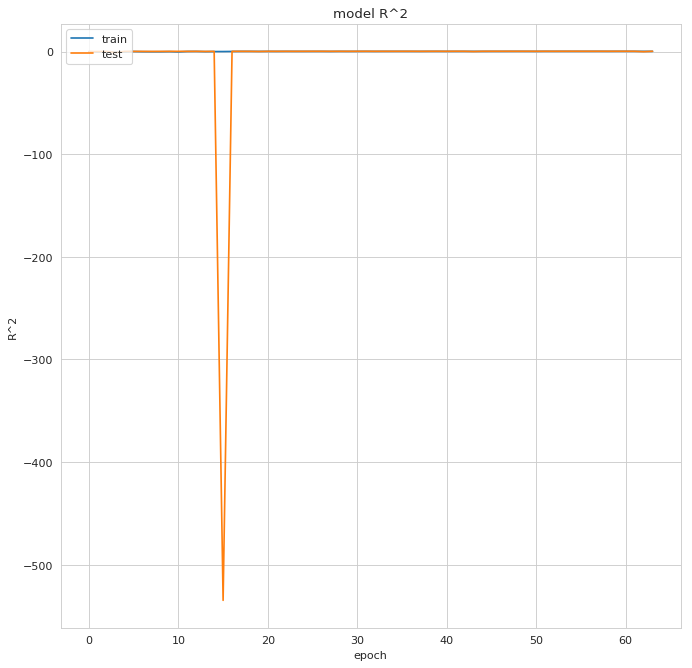

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result.history['val_r_square'])
plt.plot(result.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

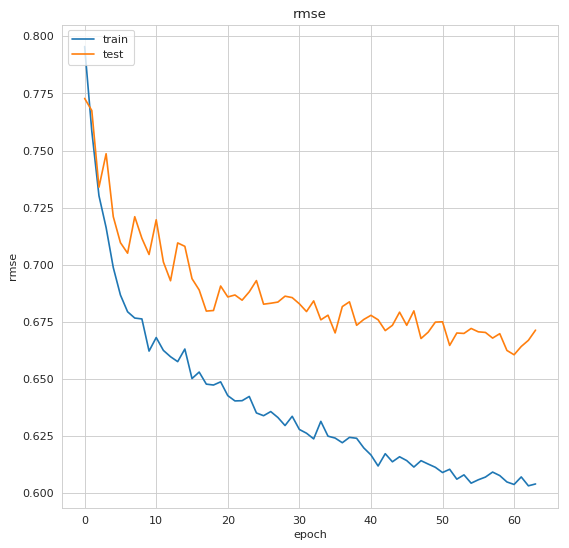

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

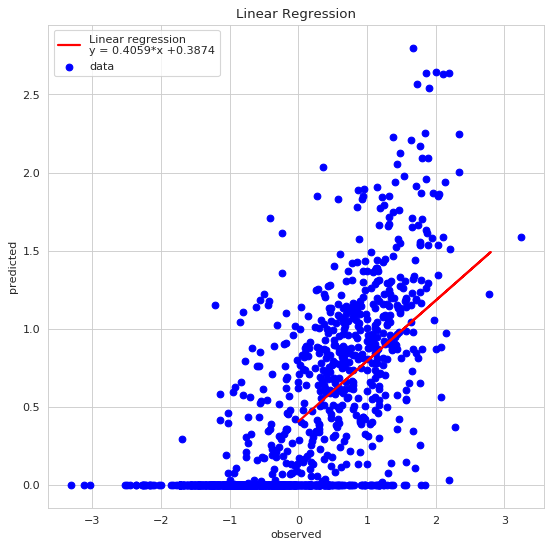

In [0]:
# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(y0_test.reshape(-1,1), y_pred)  
y_fit = regressor.predict(y_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y0_test, y_pred, color='blue', label= 'data')
plt.plot(y_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [0]:
#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y0_test,y_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y0_test,y_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y0_test,y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y0_test,y_pred))



Mean absolute error (MAE):      0.671323
Mean squared error (MSE):       0.713519
Root mean squared error (RMSE): 0.844700
R square (R^2):                 0.293410


###### Validation prediction 

In [0]:
valid_pred = model0.predict(X_test_val)

In [0]:
print("\n")
valid_pred = model0.predict(X_test_val)
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y_test_val,valid_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y_test_val,valid_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_test_val,valid_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_test_val,valid_pred))



Mean absolute error (MAE):      0.725024
Mean squared error (MSE):       0.810222
Root mean squared error (RMSE): 0.900123
R square (R^2):                 0.276284


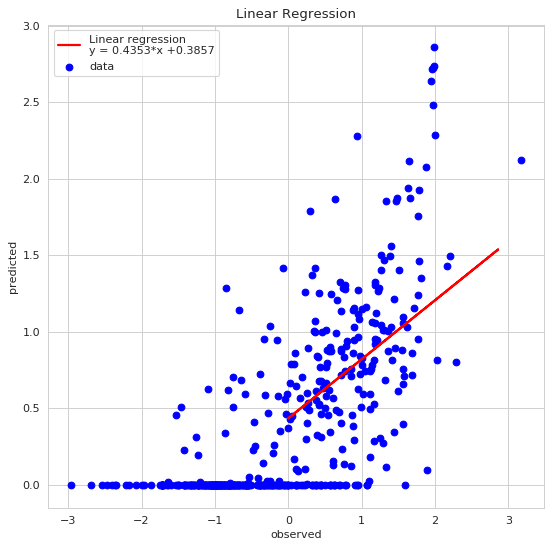

In [0]:
# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
regressor.fit(y_test_val.reshape(-1,1), valid_pred)  
y_fit = regressor.predict(valid_pred) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_test_val, valid_pred, color='blue', label= 'data')
plt.plot(valid_pred, y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [0]:
#Add noise of 0.01 to the dataframe
noise = add_gausian(df0,0,0.1)
df1 = pd.concat([df0,noise])




df1.shape

(8350, 117)

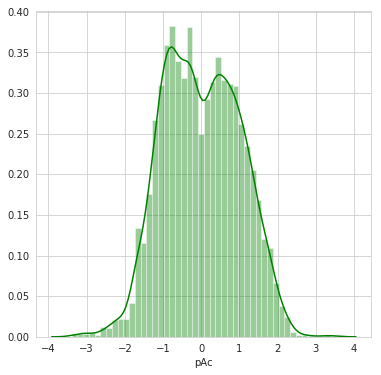

In [0]:
#Plot distribution of the pAc with the density estimation function after scaling
f, ax = plt.subplots(figsize=(6, 6))
sns.distplot(df1.pAc,color = 'green');
sns.set_style("whitegrid")

In [0]:
# Get the feature vector
X1 = df1.drop(columns=['pAc'],axis=1).values
# Get the target vector
y1 = df1["pAc"].values
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3,random_state=42)

###### Fit the training data after first round of noise addition and evaluate the model

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model1 = Sequential()
# add batch normalization
model1.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model1.add(Dense(units=300, activation='relu', input_dim=X1_train.shape[1]))
# add output layer
model1.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model1.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result = model1.fit(X1_train, y1_train, epochs=100, batch_size=500, validation_data=(X1_test, y1_test), callbacks=[earlystopping])
# get predictions
y1_pred = model1.predict(X1_test)

Train on 5845 samples, validate on 2505 samples
Epoch 1/100
5845/5845 [==============================] - 3s 574us/step - loss: 1.0282 - mean_squared_error: 1.0282 - rmse: 0.8340 - r_square: -0.0471 - val_loss: 0.9499 - val_mean_squared_error: 0.9499 - val_rmse: 0.8128 - val_r_square: 0.0607
Epoch 2/100
5845/5845 [==============================] - 0s 23us/step - loss: 0.8886 - mean_squared_error: 0.8886 - rmse: 0.7816 - r_square: 0.0943 - val_loss: 0.8970 - val_mean_squared_error: 0.8970 - val_rmse: 0.7841 - val_r_square: 0.1136
Epoch 3/100
5845/5845 [==============================] - 0s 22us/step - loss: 0.8496 - mean_squared_error: 0.8496 - rmse: 0.7601 - r_square: 0.1327 - val_loss: 0.8465 - val_mean_squared_error: 0.8465 - val_rmse: 0.7571 - val_r_square: 0.1621
Epoch 4/100
5845/5845 [==============================] - 0s 23us/step - loss: 0.7964 - mean_squared_error: 0.7964 - rmse: 0.7299 - r_square: 0.1887 - val_loss: 0.7910 - val_mean_squared_error: 0.7910 - val_rmse: 0.7240 - val

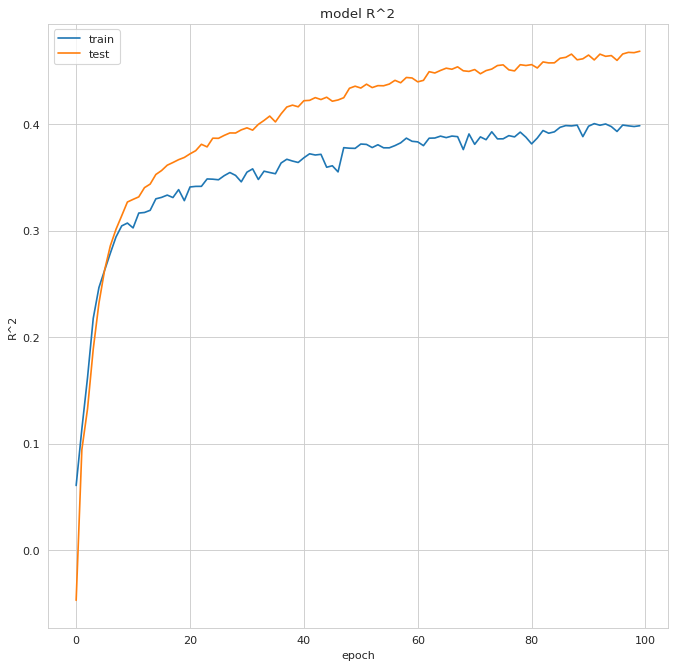

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result.history['val_r_square'])
plt.plot(result.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

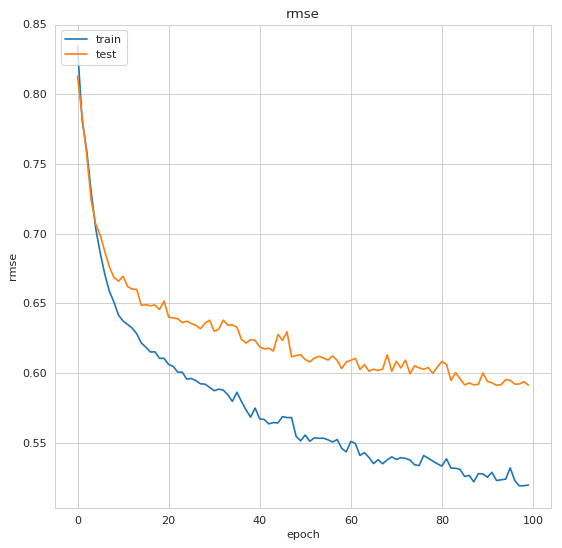

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y1_test,y1_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y1_test,y1_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y1_test,y1_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y1_test,y1_pred))



Mean absolute error (MAE):      0.591492
Mean squared error (MSE):       0.608392
Root mean squared error (RMSE): 0.779995
R square (R^2):                 0.399695


###### Prediction with Validation set 

In [0]:
#valid_pred = svr.predict(X_test_val)
valid_pred1 = model1.predict(X_test_val)
print(mean_squared_error(y_test_val,valid_pred1))
print(r2_score(y_test_val,valid_pred1))

0.7859066860005557
0.29800317799208


In [0]:
#Add noise 0.2 to original data frame and augment dataframe 
#Train and evaluate after augmentation

In [0]:
#Add noise of 0.02 to the dataframe
noise = add_gausian(df0,0,0.2)
df2=pd.concat([df1,noise])
df2.shape

(12525, 117)

In [0]:
#Plot distribution of the pAc with the density estimation function after scaling
#f, ax = plt.subplots(figsize=(6, 6))
#sns.distplot(df2.pAc,color = 'red');
#sns.set_style("whitegrid")

In [0]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X2 = df2.drop(columns=['pAc'],axis=1).values
# Get the target vector
y2 = df2["pAc"].values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3,random_state=42)

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model2 = Sequential()
# add batch normalization
model2.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model2.add(Dense(units=300, activation='relu', input_dim=X2_train.shape[1]))
# add output layer
model2.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result2 = model2.fit(X2_train, y2_train, epochs=100, batch_size=500, validation_data=(X2_test, y2_test), callbacks=[earlystopping])
# get predictions
y2_pred = model2.predict(X2_test)

Train on 8767 samples, validate on 3758 samples
Epoch 1/100
8767/8767 [==============================] - 4s 416us/step - loss: 1.0047 - mean_squared_error: 1.0047 - rmse: 0.8304 - r_square: -0.0057 - val_loss: 0.8861 - val_mean_squared_error: 0.8861 - val_rmse: 0.7729 - val_r_square: 0.1196
Epoch 2/100
8767/8767 [==============================] - 0s 25us/step - loss: 0.8659 - mean_squared_error: 0.8659 - rmse: 0.7669 - r_square: 0.1329 - val_loss: 0.8284 - val_mean_squared_error: 0.8284 - val_rmse: 0.7413 - val_r_square: 0.1772
Epoch 3/100
8767/8767 [==============================] - 0s 24us/step - loss: 0.8071 - mean_squared_error: 0.8071 - rmse: 0.7326 - r_square: 0.1929 - val_loss: 0.7862 - val_mean_squared_error: 0.7862 - val_rmse: 0.7170 - val_r_square: 0.2184
Epoch 4/100
8767/8767 [==============================] - 0s 23us/step - loss: 0.7489 - mean_squared_error: 0.7489 - rmse: 0.6998 - r_square: 0.2511 - val_loss: 0.7425 - val_mean_squared_error: 0.7425 - val_rmse: 0.6905 - val

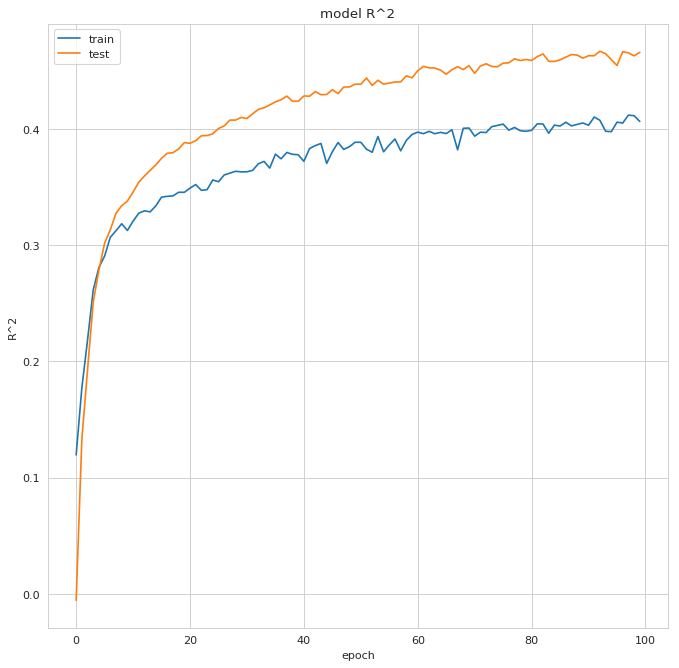

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result2.history['val_r_square'])
plt.plot(result2.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

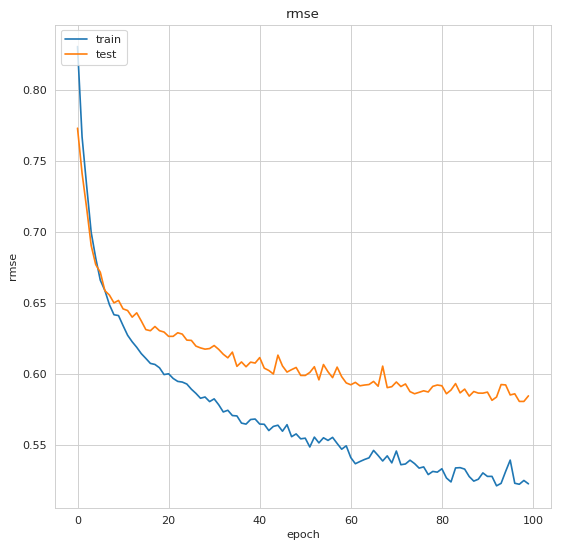

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result2.history['rmse'])
plt.plot(result2.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y2_test,y2_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y2_test,y2_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y2_test,y2_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y2_test,y2_pred))



Mean absolute error (MAE):      0.584803
Mean squared error (MSE):       0.597372
Root mean squared error (RMSE): 0.772898
R square (R^2):                 0.408433


In [0]:
#Evaluate model2 on validation prediction
valid_pred2 = model2.predict(X_test_val)
print(mean_squared_error(y_test_val,valid_pred2))
print(r2_score(y_test_val,valid_pred2))

0.7855214488356893
0.2983472840676138


In [0]:
#Add noise of 0.03 to the dataframe
noise3 = add_gausian(df0,0,0.3)

df3 = pd.concat([df2,noise3])
df3.shape

(16700, 117)

In [0]:
#Plot distribution of the pAc with the density estimation function after scaling
#f, ax = plt.subplots(figsize=(6, 6))
#sns.distplot(df2.pAc,color = 'blue');
#sns.set_style("whitegrid")

In [0]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X3 = df3.drop(columns=['pAc'],axis=1).values
# Get the target vector
y3 = df3["pAc"].values
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3,random_state=42)

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model3 = Sequential()
# add batch normalization
model3.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model3.add(Dense(units=300, activation='relu', input_dim=X3_train.shape[1]))
# add output layer
model3.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model3.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result3 = model3.fit(X3_train, y3_train, epochs=100, batch_size=500, validation_data=(X3_test, y3_test), callbacks=[earlystopping])
# get predictions
y3_pred = model3.predict(X3_test)

Train on 11690 samples, validate on 5010 samples
Epoch 1/100
11690/11690 [==============================] - 4s 317us/step - loss: 1.0048 - mean_squared_error: 1.0048 - rmse: 0.8252 - r_square: 0.0135 - val_loss: 0.9037 - val_mean_squared_error: 0.9037 - val_rmse: 0.7840 - val_r_square: 0.1200
Epoch 2/100
11690/11690 [==============================] - 0s 23us/step - loss: 0.8808 - mean_squared_error: 0.8808 - rmse: 0.7678 - r_square: 0.1367 - val_loss: 0.8246 - val_mean_squared_error: 0.8246 - val_rmse: 0.7428 - val_r_square: 0.1970
Epoch 3/100
11690/11690 [==============================] - 0s 22us/step - loss: 0.8011 - mean_squared_error: 0.8011 - rmse: 0.7234 - r_square: 0.2140 - val_loss: 0.7804 - val_mean_squared_error: 0.7804 - val_rmse: 0.7136 - val_r_square: 0.2388
Epoch 4/100
11690/11690 [==============================] - 0s 22us/step - loss: 0.7507 - mean_squared_error: 0.7507 - rmse: 0.6929 - r_square: 0.2630 - val_loss: 0.7369 - val_mean_squared_error: 0.7369 - val_rmse: 0.68

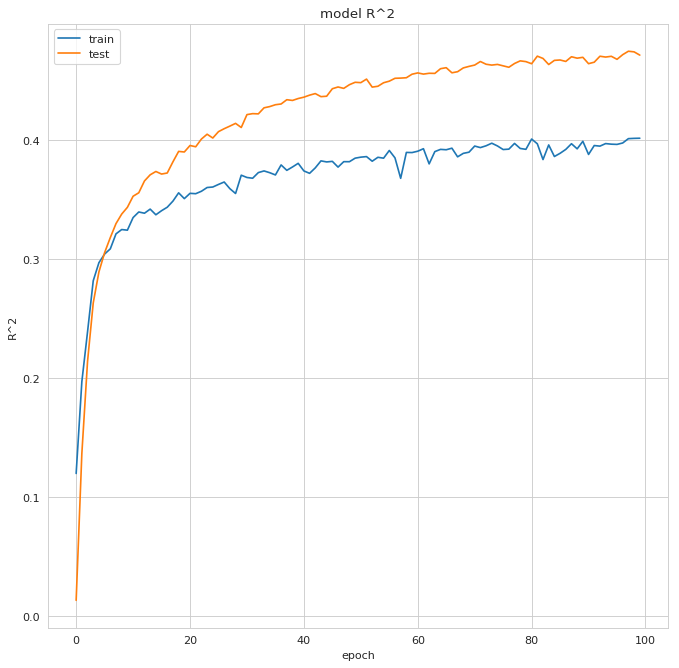

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result3.history['val_r_square'])
plt.plot(result3.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

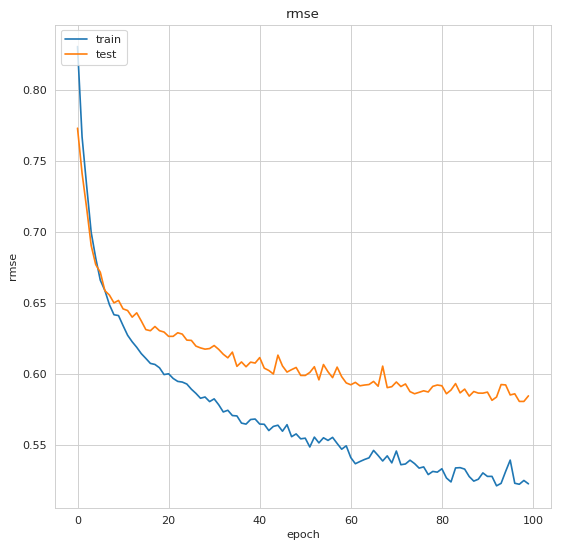

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result2.history['rmse'])
plt.plot(result2.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#-----------------------------------------------------------------------------
# print statistical figures of merit
#-----------------------------------------------------------------------------

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y3_test,y3_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y3_test,y3_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y3_test,y3_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y3_test,y3_pred))



Mean absolute error (MAE):      0.598651
Mean squared error (MSE):       0.614370
Root mean squared error (RMSE): 0.783818
R square (R^2):                 0.402193


In [0]:
##Evaluate model3 on validation prediction
valid_pred3 = model3.predict(X_test_val)
print(mean_squared_error(y_test_val,valid_pred3))
print(r2_score(y_test_val,valid_pred3))

0.7687168580075409
0.3133576785160145


In [0]:
#Add noise of 0.04 to the dataframe
noise = add_gausian(df,0,0.4)
df4 = pd.concat([df3,noise])
df4.shape

(20875, 117)

In [0]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X4 = df4.drop(columns=['pAc'],axis=1).values
# Get the target vector
y4 = df4["pAc"].values
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3,random_state=42)

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model4 = Sequential()
# add batch normalization
model4.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model4.add(Dense(units=300, activation='relu', input_dim=X4_train.shape[1]))
# add output layer
model4.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model4.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result4 = model4.fit(X4_train, y4_train, epochs=100, batch_size=500, validation_data=(X4_test, y4_test), callbacks=[earlystopping])
# get predictions
y4_pred = model4.predict(X4_test)

Train on 14612 samples, validate on 6263 samples
Epoch 1/100
14612/14612 [==============================] - 4s 262us/step - loss: 0.9762 - mean_squared_error: 0.9762 - rmse: 0.8104 - r_square: 0.0556 - val_loss: 0.9009 - val_mean_squared_error: 0.9009 - val_rmse: 0.7744 - val_r_square: 0.1528
Epoch 2/100
14612/14612 [==============================] - 0s 20us/step - loss: 0.8405 - mean_squared_error: 0.8405 - rmse: 0.7456 - r_square: 0.1889 - val_loss: 0.8228 - val_mean_squared_error: 0.8228 - val_rmse: 0.7273 - val_r_square: 0.2263
Epoch 3/100
14612/14612 [==============================] - 0s 23us/step - loss: 0.7778 - mean_squared_error: 0.7778 - rmse: 0.7088 - r_square: 0.2499 - val_loss: 0.7800 - val_mean_squared_error: 0.7800 - val_rmse: 0.7030 - val_r_square: 0.2666
Epoch 4/100
14612/14612 [==============================] - 0s 21us/step - loss: 0.7466 - mean_squared_error: 0.7466 - rmse: 0.6894 - r_square: 0.2797 - val_loss: 0.7627 - val_mean_squared_error: 0.7627 - val_rmse: 0.69

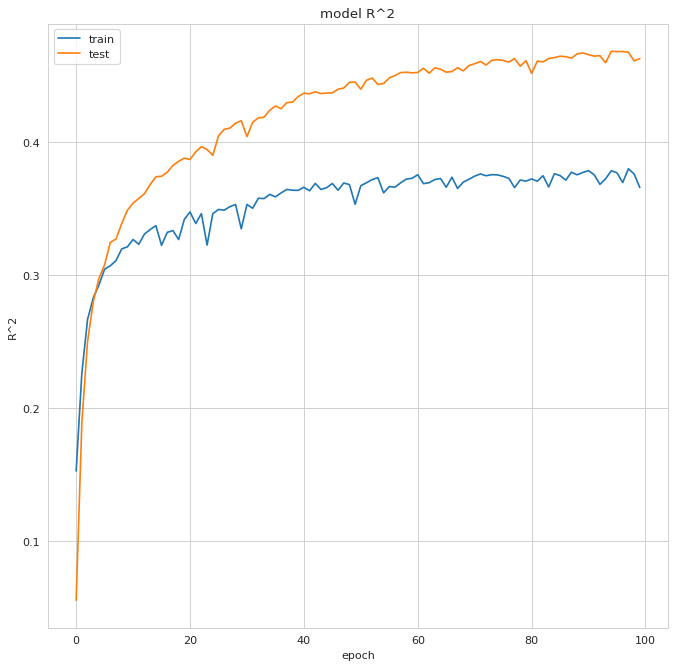

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result4.history['val_r_square'])
plt.plot(result4.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

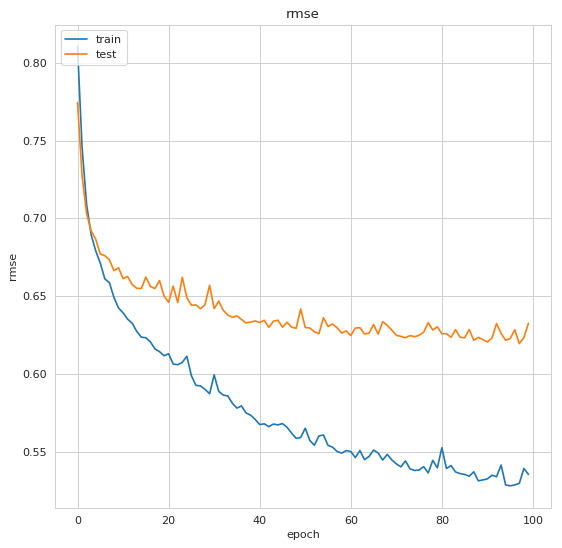

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result4.history['rmse'])
plt.plot(result4.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y4_test,y4_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y4_test,y4_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y4_test,y4_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y4_test,y4_pred))



Mean absolute error (MAE):      0.632520
Mean squared error (MSE):       0.674682
Root mean squared error (RMSE): 0.821390
R square (R^2):                 0.367210


In [0]:
#valid_pred = svr.predict(X_test_val)
valid_pred4 = model4.predict(X_test_val)
print(mean_squared_error(y_test_val,valid_pred4))
print(r2_score(y_test_val,valid_pred4))

0.7879197315340762
0.2962050617624291


In [0]:
#Add noise of 0.05 to the dataframe
noise = add_gausian(df0,0,0.5)
df5 = pd.concat([df4,noise])
df5.shape

(25050, 117)

In [0]:
# Get the feature vector
#X = df.drop('smiles', 'mol', 'pAc', axis=1)
X5 = df5.drop(columns=['pAc'],axis=1).values
# Get the target vector
y5 = df5["pAc"].values
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.3,random_state=42)

In [0]:
#-----------------------------------------------------------------------------
# Start a simple Keras sequential model
#-----------------------------------------------------------------------------

# set the seeds for reproducible results with TF (wont work with GPU, only CPU)
np.random.seed(7)
# set the TF seed
set_random_seed(7)
# built Keras sequential model 
model5 = Sequential()
# add batch normalization
model5.add(BatchNormalization())
# add layer to the MLP for data (404,13) 
model5.add(Dense(units=300, activation='relu', input_dim=X5_train.shape[1]))
# add output layer
model5.add(Dense(units=1, activation='relu'))
# compile regression model loss should be mean_squared_error //
model5.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])
# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')
# fit model
result5 = model5.fit(X5_train, y5_train, epochs=100, batch_size=500, validation_data=(X5_test, y5_test), callbacks=[earlystopping])
# get predictions
y5_pred = model5.predict(X5_test)

Train on 17535 samples, validate on 7515 samples
Epoch 1/100
17535/17535 [==============================] - 4s 231us/step - loss: 1.0266 - mean_squared_error: 1.0266 - rmse: 0.8310 - r_square: 0.0410 - val_loss: 0.9690 - val_mean_squared_error: 0.9690 - val_rmse: 0.8040 - val_r_square: 0.0970
Epoch 2/100
17535/17535 [==============================] - 0s 22us/step - loss: 0.9114 - mean_squared_error: 0.9114 - rmse: 0.7773 - r_square: 0.1493 - val_loss: 0.8983 - val_mean_squared_error: 0.8983 - val_rmse: 0.7670 - val_r_square: 0.1625
Epoch 3/100
17535/17535 [==============================] - 0s 21us/step - loss: 0.8334 - mean_squared_error: 0.8334 - rmse: 0.7354 - r_square: 0.2208 - val_loss: 0.8360 - val_mean_squared_error: 0.8360 - val_rmse: 0.7295 - val_r_square: 0.2198
Epoch 4/100
17535/17535 [==============================] - 0s 22us/step - loss: 0.7862 - mean_squared_error: 0.7862 - rmse: 0.7087 - r_square: 0.2660 - val_loss: 0.8111 - val_mean_squared_error: 0.8111 - val_rmse: 0.71

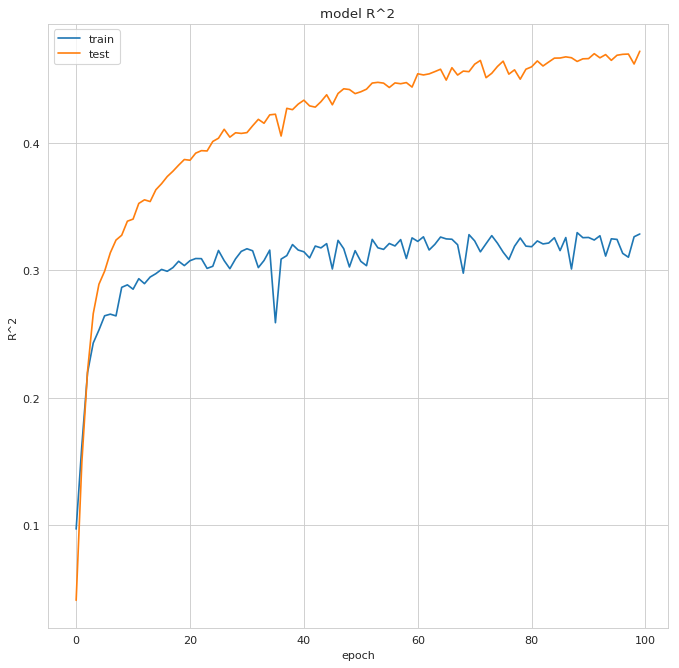

In [0]:
#-----------------------------------------------------------------------------
# Plot learning curves including R^2 and RMSE
#-----------------------------------------------------------------------------

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(result5.history['val_r_square'])
plt.plot(result5.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

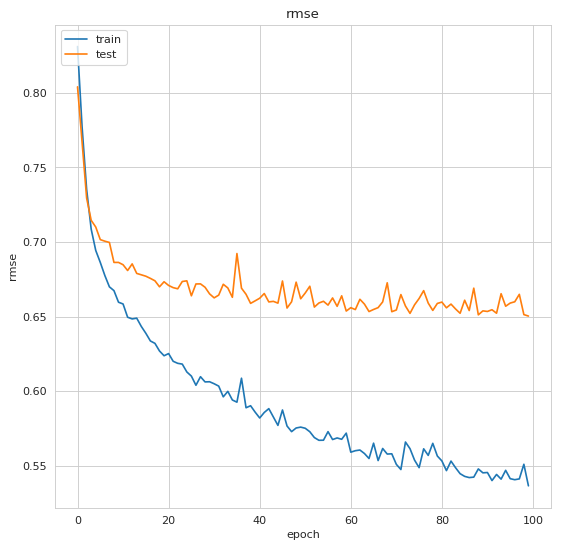

In [0]:
# plot training curve for rmse
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(result5.history['rmse'])
plt.plot(result5.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:

import sklearn.metrics, math
print("\n")
print("Mean absolute error (MAE):      %f" % sklearn.metrics.mean_absolute_error(y5_test,y5_pred))
print("Mean squared error (MSE):       %f" % sklearn.metrics.mean_squared_error(y5_test,y5_pred))
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y5_test,y5_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y5_test,y5_pred))



Mean absolute error (MAE):      0.650403
Mean squared error (MSE):       0.719101
Root mean squared error (RMSE): 0.847998
R square (R^2):                 0.331872


In [0]:
#valid_pred = svr.predict(X_test_val)
valid_pred5 = model5.predict(X_test_val)
print(mean_squared_error(y_test_val,valid_pred5))
print(r2_score(y_test_val,valid_pred5))

0.7847089370670605
0.29907304539473034
